# Train a VAE on Cell Painting LINCS Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf


In [2]:
# %load_ext nb_black

In [3]:
# np.random.seed(123)
# python_random.seed(123)
# tf.random.set_random_seed(1234)

In [4]:
data_splits = ["train", "test", "valid","complete"]
data_dict = load_data(data_splits)

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
Valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")


complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [6]:
print(train_features_df.shape)
train_features_df.head(3)

(40242, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19790,0.69605,0.40400,0.30834,0.19317,0.71895,0.38837,0.38668,0.62494,0.87362,...,0.61045,0.41907,0.64945,0.65199,0.22660,0.32108,0.29776,0.26173,0.34524,0.32151
1,0.18605,0.68873,0.41051,0.31982,0.19885,0.72510,0.39552,0.38362,0.65094,0.89679,...,0.61393,0.38269,0.63814,0.68204,0.23700,0.32808,0.27981,0.26893,0.34938,0.33179
2,0.19083,0.66276,0.38585,0.31437,0.20415,0.71380,0.38701,0.36699,0.60932,0.88492,...,0.60850,0.41850,0.63529,0.65208,0.22852,0.32710,0.29371,0.27159,0.33871,0.31965


In [7]:
print(test_features_df.shape)
test_features_df.head(3)

(5030, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19050,0.68937,0.39383,0.33072,0.20185,0.72292,0.38085,0.37504,0.61905,0.88361,...,0.60356,0.39345,0.63470,0.63406,0.23588,0.36061,0.30092,0.23638,0.36015,0.32779
1,0.18661,0.67731,0.39621,0.32318,0.20716,0.70964,0.39401,0.37779,0.60275,0.88912,...,0.60936,0.40380,0.64406,0.64859,0.22752,0.29811,0.29430,0.25475,0.34154,0.32013
2,0.18626,0.67036,0.41101,0.31863,0.20182,0.71139,0.40302,0.38979,0.59188,0.86857,...,0.61009,0.40904,0.64250,0.63285,0.23931,0.33179,0.28571,0.24980,0.34516,0.32968


In [8]:
print(complete_features_df.shape)
complete_features_df.head(3)

(50303, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19575,0.67566,0.40288,0.32633,0.20267,0.71477,0.39122,0.38048,0.61184,0.88375,...,0.60865,0.38869,0.65364,0.65716,0.24912,0.33129,0.28864,0.27106,0.35254,0.32675
1,0.18472,0.66556,0.39721,0.30968,0.20009,0.71345,0.39953,0.37314,0.61074,0.87695,...,0.60682,0.39779,0.64013,0.63120,0.24380,0.30471,0.28554,0.27852,0.35157,0.31637
2,0.18254,0.69650,0.39596,0.33502,0.20420,0.72770,0.39590,0.37023,0.60264,0.88038,...,0.60665,0.39705,0.66616,0.62889,0.25125,0.33549,0.29656,0.25706,0.33868,0.31901


In [9]:
# VAE of one layer
# encoder_architecture = [500,250,100]
# decoder_architecture = [100,250,500]
encoder_architecture = [250]
decoder_architecture = [250]


# encoder_architecture = [500,500,250,100]
# decoder_architecture = [100,250,500,500]



In [35]:
# model from optimal hyperparameters for onelayer obtained from 1.optimize
# cp_vae = VAE(
#     input_dim=train_features_df.shape[1],
#     latent_dim=5,
#     batch_size=32,
#     encoder_batch_norm=True,
#     epochs=14,
#     learning_rate=0.001,
#     encoder_architecture=encoder_architecture,
#     decoder_architecture=decoder_architecture,
#     beta=1,
#     verbose=True,
# )
# cp_vae = VAE(
#     input_dim=train_features_df.shape[1],
#     latent_dim=45,
#     batch_size=128,
#     encoder_batch_norm=False,
#     epochs=50,
#     learning_rate=0.0001,
#     encoder_architecture=encoder_architecture,
#     decoder_architecture=decoder_architecture,
#     beta=1,
#     verbose=True,
# )
# cp_vae = VAE(
#     input_dim=train_features_df.shape[1],
#     latent_dim=80,
#     batch_size=192,
#     encoder_batch_norm=False,
#     epochs=300,
#     learning_rate=0.001,
#     encoder_architecture=encoder_architecture,
#     decoder_architecture=decoder_architecture,
#     beta=1.0,
#     verbose=True,
# )
# cp_vae = VAE(
#     input_dim=train_features_df.shape[1],
#     latent_dim=80,
#     batch_size=192,
#     encoder_batch_norm=False,
#     epochs=200,
#     learning_rate=0.001,
#     encoder_architecture=encoder_architecture,
#     decoder_architecture=decoder_architecture,
#     beta=1.0,
#     verbose=True,
# )
# cp_vae = VAE(
#     input_dim=train_features_df.shape[1],
#     latent_dim=5,
#     batch_size=320,
#     encoder_batch_norm=True,
#     epochs=50,
#     learning_rate=0.01,
#     encoder_architecture=encoder_architecture,
#     decoder_architecture=decoder_architecture,
#     beta=50,
#     verbose=True,
# )
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=25,
    batch_size=160,
    encoder_batch_norm=True,
    epochs=100,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=0.05,
    verbose=True,
)
cp_vae.compile_vae()

In [36]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/100
252/252 [==============================] - 3s 7ms/step - loss: 40.7898 - val_loss: 7.5916
Epoch 2/100
252/252 [==============================] - 2s 6ms/step - loss: 2.8462 - val_loss: 1.8102
Epoch 3/100
252/252 [==============================] - 2s 6ms/step - loss: 1.4638 - val_loss: 1.1149
Epoch 4/100
252/252 [==============================] - 2s 6ms/step - loss: 1.0455 - val_loss: 0.9580
Epoch 5/100
252/252 [==============================] - 2s 6ms/step - loss: 0.9085 - val_loss: 0.8508
Epoch 6/100
252/252 [==============================] - 2s 6ms/step - loss: 0.8964 - val_loss: 0.8247
Epoch 7/100
252/252 [==============================] - 2s 6ms/step - loss: 0.8655 - val_loss: 0.8107
Epoch 8/100
252/252 [==============================] - 2s 6ms/step - loss: 0.8412 - val_loss: 0.7942
Epoch 9/100
252/252 [==============================] - 2s 7ms/step - loss: 0.8469 - val_loss: 0.7832
Epoch 10/100
252/252 [==============================] - 2s 6ms/step - loss: 0.8179 - val_l

252/252 [==============================] - 2s 6ms/step - loss: 0.6826 - val_loss: 0.6635
Epoch 82/100
252/252 [==============================] - 2s 6ms/step - loss: 0.6780 - val_loss: 0.6582
Epoch 83/100
252/252 [==============================] - 2s 6ms/step - loss: 0.6751 - val_loss: 0.6515
Epoch 84/100
252/252 [==============================] - 2s 6ms/step - loss: 0.6796 - val_loss: 0.6626
Epoch 85/100
252/252 [==============================] - 2s 6ms/step - loss: 0.6835 - val_loss: 0.6490
Epoch 86/100
252/252 [==============================] - 2s 6ms/step - loss: 0.6802 - val_loss: 0.6490
Epoch 87/100
252/252 [==============================] - 2s 6ms/step - loss: 0.6824 - val_loss: 0.7109
Epoch 88/100
252/252 [==============================] - 2s 6ms/step - loss: 0.6850 - val_loss: 0.6616
Epoch 89/100
252/252 [==============================] - 2s 6ms/step - loss: 0.6684 - val_loss: 0.6396
Epoch 90/100
252/252 [==============================] - 2s 6ms/step - loss: 0.6788 - val_loss: 

In [37]:
cp_vae.vae

In [38]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,val_loss
0,14.367666,7.591573
1,2.405485,1.810245
2,1.322589,1.114856
3,1.011588,0.957970
4,0.910566,0.850794
...,...,...
95,0.677304,0.651933
96,0.677290,0.696907
97,0.677350,0.642426
98,0.677860,0.640382


In [39]:
history_df.to_csv('level4_training.csv')

In [40]:
history_df = pd.read_csv('level4_training.csv')

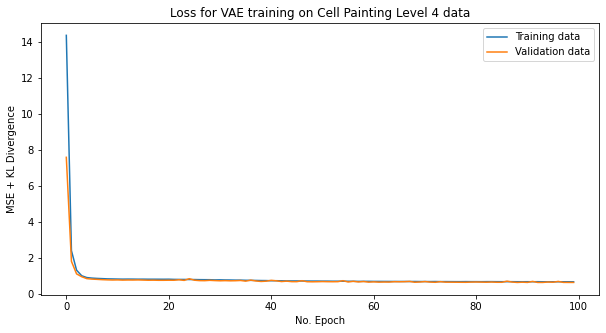

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on Cell Painting Level 4 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [42]:
cp_vae.vae.evaluate(test_features_df)

158/158 [==============================] - 0s 1ms/step - loss: 0.6456


0.6456254124641418

In [43]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

53.46813041348983

<AxesSubplot:>

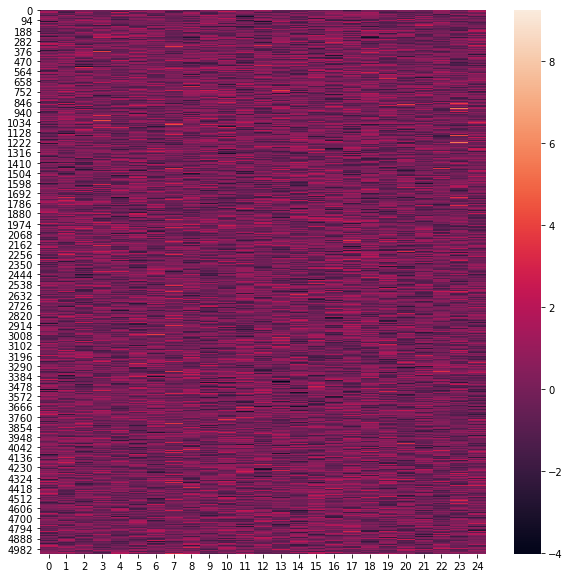

In [44]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [45]:
#original vs reconstructed heatmap
#use these 3 lines if you need to regenerate it
# encoder = keras.models.load_model("level4Encoder")
# decoder = keras.models.load_model("level4Decoder")
# reconstruction = pd.DataFrame(decoder.predict(encoder.predict(test_features_df)[2]), columns=cp_features)

reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
# seaborn.heatmap(test_features_df, ax=ax1)
# seaborn.heatmap(reconstruction, ax=ax2)
# plt.show()

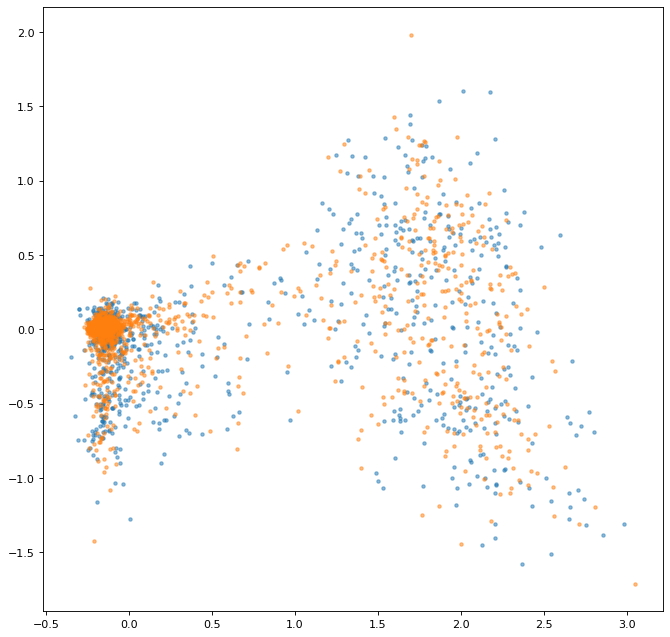

In [46]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)

In [47]:
# #difference between original and reconstructed heatmap
# difference = abs(reconstruction - test_features_df)
# fig, ax = plt.subplots(figsize=(10, 10))
# seaborn.heatmap(difference, ax=ax, cmap="Blues")

In [48]:
# #encoder heatmap
# weights = cp_vae.encoder_block["encoder"].get_weights()
# fig, ax = plt.subplots(figsize=(10, 10))
# seaborn.heatmap(weights[0], ax=ax)

In [49]:
# latent_dims = np.arange(1,51)
# reconstructions = []

# for latent_dim in latent_dims:
#     cp_vae2 = VAE(
#         input_dim=train_features_df.shape[1],
#         latent_dim=latent_dim,
#         batch_size=32,
#         encoder_batch_norm=True,
#         epochs=14,
#         learning_rate=0.01,
#         encoder_architecture=encoder_architecture,
#         decoder_architecture=decoder_architecture,
#         beta=1,
#         verbose=True,
#     )
#     cp_vae2.compile_vae()
#     cp_vae2.train(x_train=train_features_df, x_test=test_features_df)
#     reconstruction = pd.DataFrame(cp_vae2.vae.predict(test_features_df), columns=cp_features)
#     reconstructions.append(reconstruction)


In [50]:
# frobenius_norms = []
# for reconstruction in reconstructions:
#     frobenius_norms.append(
#         (sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5
#     )

In [51]:
# plt.plot(frobenius_norms)
# plt.xlabel("latent_dim")
# plt.ylabel("Frobenius Norm")
# plt.title("Cell Painting VAE")
# plt.show()

In [52]:
decoder = cp_vae.decoder_block["decoder"]

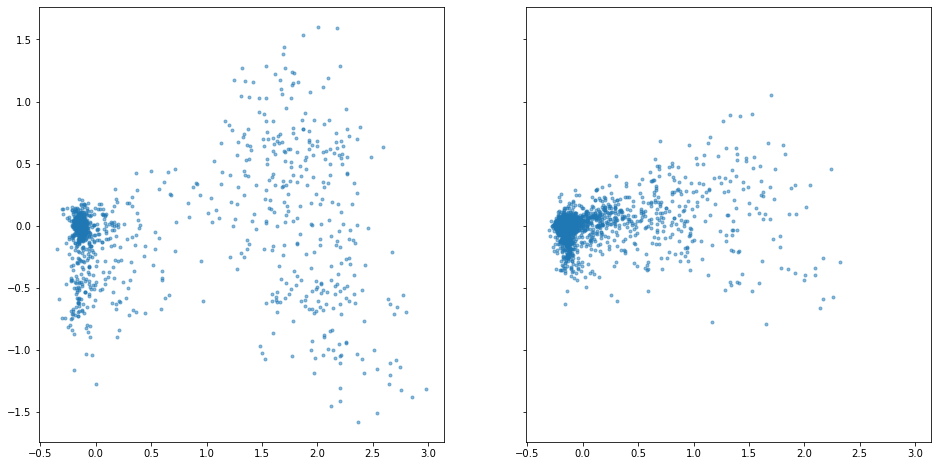

In [53]:
simulated_df = pd.DataFrame(np.random.normal(size=(5000, 25)), columns=np.arange(0,25))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca.transform(reconstruction_of_simulated))
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [54]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/level4Latent.csv")

In [55]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save("level4Decoder")

INFO:tensorflow:Assets written to: level4Decoder/assets


In [56]:
encoder.save("level4Encoder")

INFO:tensorflow:Assets written to: level4Encoder/assets
